In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
import pandas as pd
import os

In [5]:
# %pip install biopython

import Bio
from Bio.SeqUtils import GC
from Bio.Data import CodonTable
from Bio import Entrez
from Bio import SeqIO
from Bio import pairwise2 as pw
from Bio import AlignIO
from Bio import Align as al
EMAIL = 's1905547@ed.ac.uk'
Entrez.email = EMAIL

sfari_file = "../sources/SFARI-Gene_genes_11-07-2022release_11-26-2022export.csv"

In [181]:
sns.set_style('white', {'axes.linewidth': 4})
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

SFARI dataset

In [7]:
sfari = pd.read_csv(sfari_file)
sfari.shape[0]

1095

Gene2go

In [8]:

gene2go = pd.read_csv('../sources/gene2go.gz', compression='gzip', header=0, sep='\t')
gene2go.head()
gene2go = gene2go[gene2go['#tax_id']==9606] #restrict to humans

In [30]:
gene2go

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
811252,9606,1,GO:0003674,ND,enables,molecular_function,-,Function
811253,9606,1,GO:0005576,HDA,located_in,extracellular region,27068509,Component
811254,9606,1,GO:0005576,IDA,located_in,extracellular region,3458201,Component
811255,9606,1,GO:0005576,TAS,located_in,extracellular region,-,Component
811256,9606,1,GO:0005615,HDA,located_in,extracellular space,16502470,Component
...,...,...,...,...,...,...,...,...
1159906,9606,124188214,GO:0005634,IEA,located_in,nucleus,-,Component
1159907,9606,124188214,GO:0005694,IEA,located_in,chromosome,-,Component
1159908,9606,125316803,GO:0005515,IPI,enables,protein binding,32958672,Function
1159909,9606,125316803,GO:0005615,IDA,located_in,extracellular space,32958672,Component


Accessed 16 November 2022

## Task 1

In [9]:
mapped_genes, too_many_results, no_results = [], [], []
for index, row in sfari.iterrows():
    ensembl_id = row['ensembl-id']
    gene_symbol = row['gene-symbol']
    if pd.isnull(ensembl_id):
        # some genes don't have an ensemble id
        handle = Entrez.esearch(db="gene", retmax=2, term=f"({gene_symbol}\
            [Gene Name]) AND (Homo sapiens[Organism]) ")
    else:
        handle = Entrez.esearch(db="gene", retmax=2, term=ensembl_id)
    record = Entrez.read(handle)
    handle.close()
    count = int(record['Count'])
    if count > 1:
        # got more than one result
        too_many_results.append(row)
    elif count == 0:
        # didn't get a result
        no_results.append(row)
    else:
        gene_id = int(record['IdList'][0])
        row['gene-id'] = gene_id
        mapped_genes.append(row)
pd.DataFrame(mapped_genes).to_csv('../sources/sfari_ncbi.csv', index=False)
pd.DataFrame(too_many_results).to_csv('../sources/sfari_ncbi_over.csv', index=False)
pd.DataFrame(no_results).to_csv('../sources/sfari_ncbi_under.csv', index=False)

In [22]:

print("Number of Gene Symbols/Ensembl IDs with more than 1 Gene ID: {}".format(pd.read_csv('../sources/sfari_ncbi_over.csv').shape[0]))
print("Number of Gene Symbols/Ensembl IDs with no Gene ID: {}".format(pd.read_csv('../sources/sfari_ncbi_under.csv').shape[0]))

Number of Gene Symbols/Ensembl IDs with more than 1 Gene ID: 9
Number of Gene Symbols/Ensembl IDs with no Gene ID: 3


## Task 2

In [66]:
uid = pd.read_csv('../sources/sfari_ncbi.csv')
uid.shape[0]

1083

In [11]:
uid_go_term = gene2go.loc[gene2go['GeneID'].isin(uid["gene-id"].values), :][['GeneID','GO_term']] #list where uid from sfari is found in gene2go.loc

In [42]:
diff = np.setdiff1d(uid['gene-id'].unique(),uid_go_term['GeneID'].unique(),assume_unique=True)
diff

array([   401145,     84326,     79684, 100873065])

## Task 3

In [13]:
gene_category_scores = [1,2,3]
gene_lists_byscore = []
for i in gene_category_scores:
    select_uid = uid[uid["gene-score"] ==i]
    gene_lists_byscore.append(select_uid)
    ("GeneID:"+select_uid['gene-id'].astype(str)).to_csv('uid_lists_task3/panther_version/uid_cs_{}.txt'.format(i),index=False,header=False)
    select_uid['gene-id'].to_csv('uid_lists_task3/reactome_version/uid_cs_{}.txt'.format(i),index=False,header=['NCBI Gene'])
    


In [14]:
np.setdiff1d(diff,gene_lists_byscore[0]['gene-id'],assume_unique=True)

array([   401145,     84326,     79684, 100873065])

In [170]:
gene_lists_byscore[0]["gene-id"].to_frame(name='GeneID')

,GeneID
7,60
16,23394
18,158
20,2334
31,27245
...,...
1055,197131
1059,26137
1067,23613
1069,23036


In [173]:
l = pd.merge(gene_lists_byscore[0]["gene-id"].to_frame(name='GeneID'),gene2go,right_on='GeneID',left_on='GeneID')
l.groupby('GO_ID').size().sort_values(ascending=False)

GO_ID
GO:0005634    177
GO:0005515    168
GO:0005654    138
GO:0005886    111
GO:0005829    105
             ... 
GO:0033489      1
GO:0033484      1
GO:0033365      1
GO:0033292      1
GO:0036268      1
Length: 2574, dtype: int64

## Task 4

In [227]:
gene2go['GeneID'].drop_duplicates().count()

20742

In [244]:
gene_list_go_all = gene2go.groupby(['GO_term','GO_ID','Category'])['GeneID'].count().reset_index(name='Count').sort_values('Count',ascending=False)
gene_list_go_all['Expected Count'] =   (gene_list_go_all['Count']/gene2go['GeneID'].drop_duplicates().count())
gene_list_go_all

,GO_term,GO_ID,Category,Count,Expected Count
14370,protein binding,GO:0005515,Function,12638,0.609295
12152,plasma membrane,GO:0005886,Component,7945,0.383039
11312,nucleus,GO:0005634,Component,7538,0.363417
4932,cytosol,GO:0005829,Component,7184,0.346350
4879,cytoplasm,GO:0005737,Component,6150,0.296500
...,...,...,...,...,...
9630,negative regulation of canonical Wnt signaling...,GO:0060829,Process,1,0.000048
15208,regulation of apoptosis involved in tissue hom...,GO:0060785,Process,1,0.000048
9632,negative regulation of cardiac chamber formation,GO:1901211,Process,1,0.000048
15205,regulation of antigen processing and presentation,GO:0002577,Process,1,0.000048


In [260]:
p1 = gene2go.loc[gene2go['GeneID'].isin(gene_lists_byscore[0]["gene-id"].values), :].groupby(['GO_term','GO_ID','Category'])['GeneID'].count().reset_index(name='Count').sort_values('Count',ascending=False)
p2 = pd.merge(p1,gene_list_go_all,right_on='GO_term',left_on='GO_term')
p2['Expected Count'] = p2['Expected Count']*gene_lists_byscore[0]["gene-id"].size

p2[['GO_term','GO_ID_x','Category_x','Count_x','Expected Count']]


,GO_term,GO_ID_x,Category_x,Count_x,Expected Count
0,nucleus,GO:0005634,Component,177,77.044451
1,protein binding,GO:0005515,Function,168,129.170572
2,nucleoplasm,GO:0005654,Component,138,52.402083
3,plasma membrane,GO:0005886,Component,111,81.204320
4,cytosol,GO:0005829,Component,105,73.426285
...,...,...,...,...,...
2569,negative regulation of multicellular organism ...,GO:0040015,Process,1,0.122650
2570,"negative regulation of mitotic cell cycle, emb...",GO:0045976,Process,1,0.020442
2571,negative regulation of mitophagy,GO:1901525,Process,1,0.061325
2572,negative regulation of microtubule polymerization,GO:0031115,Process,1,0.132871


In [267]:
gene_list_tables_GOterm = []
for i in range(3):
    GO_term = gene2go.loc[gene2go['GeneID'].isin(gene_lists_byscore[i]["gene-id"].values), :].groupby(['GO_term','GO_ID','Category'])['GeneID'].count().reset_index(name='Count').sort_values('Count',ascending=False)
    # GO_term[0:] = ((100*GO_term[0:]/(len(gene_lists_byscore[i]))).round(1)).astype(str)+"%"
    p2 = pd.merge(GO_term,gene_list_go_all,right_on='GO_term',left_on='GO_term')
    p2['Expected Count'] = (p2['Expected Count']*gene_lists_byscore[i]["gene-id"].size).round(0)

    

    gene_list_tables_GOterm.append(p2[['GO_term','GO_ID_x','Category_x','Count_x','Expected Count']].head(10))

### Table 1 for Gene Score Category 1.0

In [268]:
gene_list_tables_GOterm[0]['GO_term'].values


array(['nucleus', 'protein binding', 'nucleoplasm', 'plasma membrane',
       'cytosol', 'cytoplasm',
       'positive regulation of transcription by RNA polymerase II',
       'regulation of transcription by RNA polymerase II',
       'DNA-binding transcription factor activity, RNA polymerase II-specific',
       'membrane'], dtype=object)

In [275]:
print(gene_list_tables_GOterm[2].to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))

\begin{table}
\centering
\caption{Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.}
\begin{tabular}{lllrr}
\toprule
          GO\_term &    GO\_ID\_x & Category\_x &  Count\_x &  Expected Count \\
\midrule
  protein binding & GO:0005515 &   Function &       75 &            55.0 \\
          cytosol & GO:0005829 &  Component &       61 &            32.0 \\
        cytoplasm & GO:0005737 &  Component &       48 &            27.0 \\
  plasma membrane & GO:0005886 &  Component &       47 &            35.0 \\
          nucleus & GO:0005634 &  Component &       47 &            33.0 \\
      nucleoplasm & GO:0005654 &  Component &       32 &            22.0 \\
         membrane & GO:0016020 &  Component &       25 &            17.0 \\
metal ion binding & GO:0046872 &   Function &       17 &            10.0 \\
      RNA binding & GO:0003723 &   Function &       17 &             8.0 \\
      ATP binding & GO:0005524 &   Function &       17 &             7.0 \

/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_69879/1945642011.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(gene_list_tables_GOterm[2].to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))


### Table for GSC 2.0

In [270]:
gene_list_tables_GOterm[1]

,GO_term,GO_ID_x,Category_x,Count_x,Expected Count
0,plasma membrane,GO:0005886,Component,492,263.0
1,protein binding,GO:0005515,Function,465,418.0
2,cytosol,GO:0005829,Component,303,238.0
3,nucleus,GO:0005634,Component,298,249.0
4,nucleoplasm,GO:0005654,Component,241,170.0
5,cytoplasm,GO:0005737,Component,239,203.0
6,membrane,GO:0016020,Component,165,126.0
7,metal ion binding,GO:0046872,Function,89,78.0
8,extracellular exosome,GO:0070062,Component,88,75.0
9,RNA binding,GO:0003723,Function,85,59.0


### Table for GSC 3.0

In [272]:
gene_list_tables_GOterm[2]

,GO_term,GO_ID_x,Category_x,Count_x,Expected Count
0,protein binding,GO:0005515,Function,75,55.0
1,cytosol,GO:0005829,Component,61,32.0
2,cytoplasm,GO:0005737,Component,48,27.0
3,plasma membrane,GO:0005886,Component,47,35.0
4,nucleus,GO:0005634,Component,47,33.0
5,nucleoplasm,GO:0005654,Component,32,22.0
6,membrane,GO:0016020,Component,25,17.0
7,metal ion binding,GO:0046872,Function,17,10.0
8,RNA binding,GO:0003723,Function,17,8.0
9,ATP binding,GO:0005524,Function,17,7.0


## Task 5

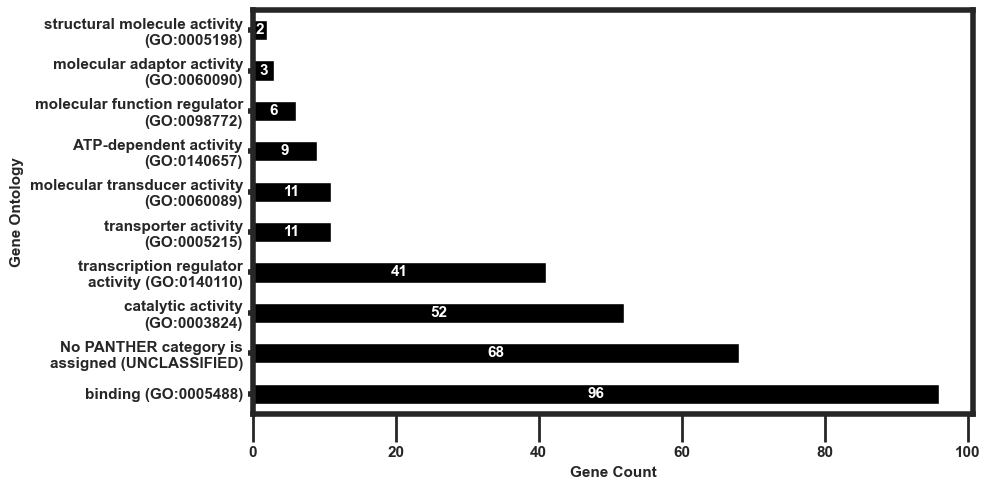

In [276]:

f = pd.read_csv('pantherChartunClassfied.txt',delimiter="	",header=None)
f.columns = ['Number','Label','Count','Percentage','Remainder']

f['Label'] = f['Label'].str.wrap(30)
# f['Percentage'] =(f['Percentage'].str.replace("%","")).astype(float)

p = f.sort_values(['Count'],ascending=False)[:10].plot(x='Label',y='Count',figsize=(10,5),kind='barh',color='black',fontsize=11,legend=False)
p.bar_label(p.containers[0],label_type='center',fontsize=11,color='white')

p.set_ylabel('Gene Ontology',fontsize=11)
p.set_xlabel('Gene Count',fontsize=11)
plt.tight_layout()

plt.show()

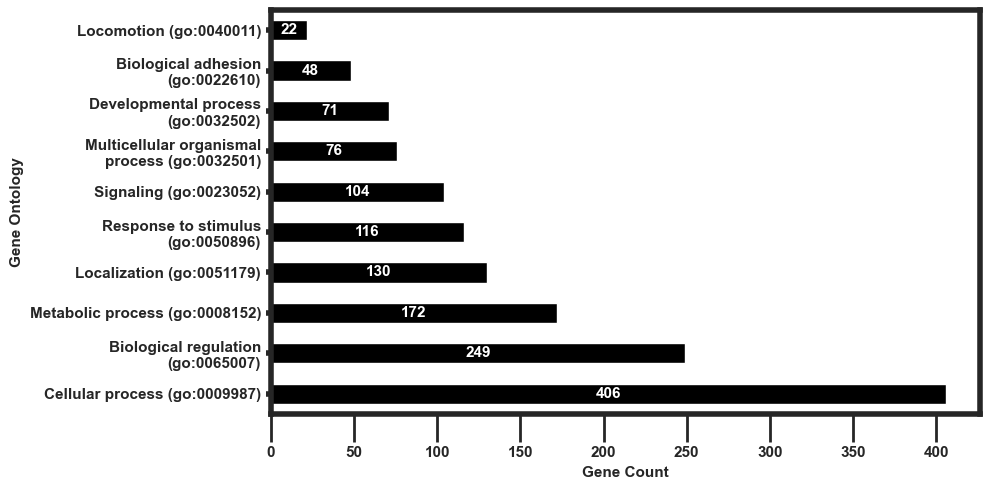

In [277]:
f = pd.read_csv('panther_task5/pantherChart_2.txt',delimiter="	",header=None)
f.columns = ['Number','Label','Count','Percentage','Remainder']
f['Label'] = f['Label'].str.capitalize()
f['Label'] = f['Label'].str.wrap(30)
# f['Percentage'] =(f['Percentage'].str.replace("%","")).astype(float)

p = f.sort_values(['Count'],ascending=False)[:10].plot(x='Label',y='Count',figsize=(10,5),kind='barh',color='black',fontsize=11,legend=False)
p.bar_label(p.containers[0],label_type='center',fontsize=11,color='white')

p.set_ylabel('Gene Ontology',fontsize=11)
p.set_xlabel('Gene Count',fontsize=11)
plt.tight_layout()

plt.show()

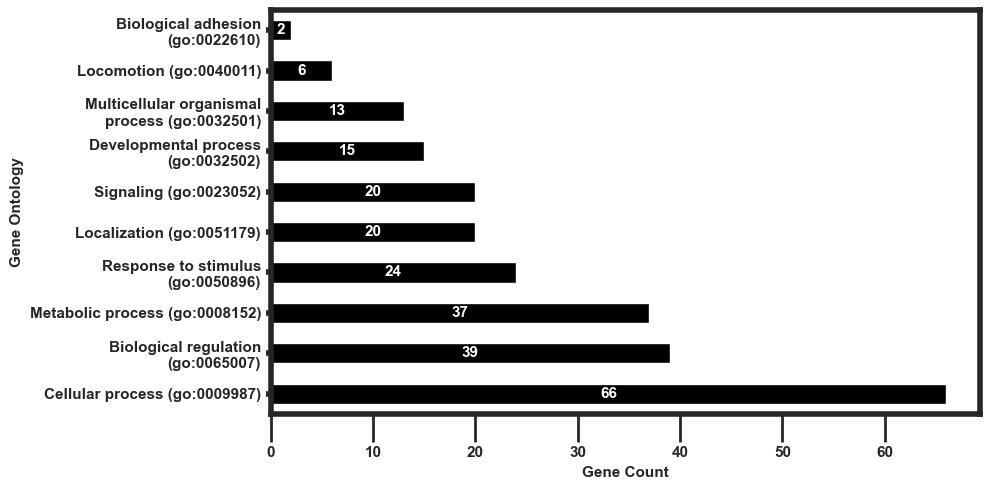

In [278]:
f = pd.read_csv('panther_task5/pantherChart_3.txt',delimiter="	",header=None)
f.columns = ['Number','Label','Count','Percentage','Remainder']
f['Label'] = f['Label'].str.capitalize()
f['Label'] = f['Label'].str.wrap(30)
f['Percentage'] =(f['Percentage'].str.replace("%","")).astype(float)

p = f.sort_values(['Count'],ascending=False)[:10].plot(x='Label',y='Count',figsize=(10,5),kind='barh',color='black',fontsize=11,legend=False)
p.bar_label(p.containers[0],label_type='center',fontsize=11,color='white')

p.set_ylabel('Gene Ontology',fontsize=11)
p.set_xlabel('Gene Count',fontsize=11)
plt.tight_layout()

plt.show()

In [279]:
or_rtm = pd.read_csv("../sources/reactome-3.csv").sort_values('Entities found',ascending=False)
# or_rtm['Entities found'] = (100*or_rtm['Entities found']/(len(gene_lists_byscore[0])-58)).round(1)
or_rtm.head()

,Pathway identifier,Pathway name,Entities found,Entities total,Entities ratio,Entities pValue,Entities FDR,Reactions found,Reactions total,Reactions ratio,Species identifier,Species name,Submitted entities found,Mapped entities,Found reaction identifiers
446,R-HSA-162582,Signal Transduction,24,3023,0.199104,0.453410,0.453410,124,2518,0.178861,9606,Homo sapiens,5140;50937;7532;5530;27;7534;29843;9181;2262;5...,NaN,R-HSA-5654614;R-HSA-390663;R-HSA-177927;R-HSA-...
711,R-HSA-1430728,Metabolism,17,3641,0.239808,0.995119,0.995119,95,2268,0.161102,9606,Homo sapiens,5167;27;9963;9435;2395;5091;2262;9791;5290;254...,NaN,R-HSA-975629;R-HSA-2404131;R-HSA-400143;R-HSA-...
664,R-HSA-168256,Immune System,16,2698,0.177699,0.896033,0.896033,254,1645,0.116849,9606,Homo sapiens,22954;5530;27;7534;22992;5290;64219;2547;2887;...,NaN,R-HSA-452100;R-HSA-452097;R-HSA-450063;R-HSA-1...
109,R-HSA-1266738,Developmental Biology,14,1279,0.084239,0.109771,0.274816,76,573,0.040702,9606,Homo sapiens,50937;27;26986;490;5290;782;2887;80205;23097;2...,NaN,R-HSA-525833;R-HSA-3928633;R-HSA-3928632;R-HSA...
673,R-HSA-392499,Metabolism of proteins,12,2214,0.145821,0.928471,0.928471,47,811,0.057608,9606,Homo sapiens,3827;4482;3479;51693;9646;27;1981;1121;26986;2...,NaN,R-HSA-8870469;R-HSA-381446;R-HSA-5694418;R-HSA...


237 not found for all
58 for C1
23 for C3
156 for C2


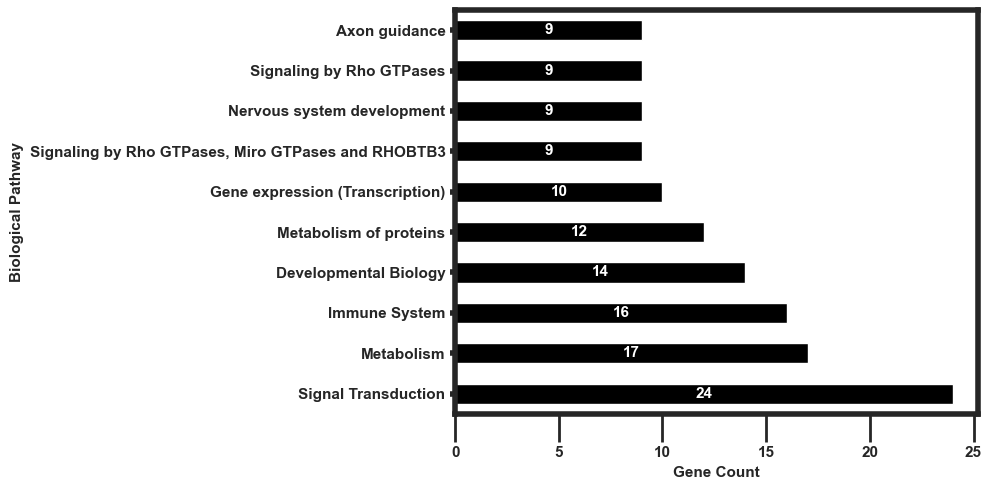

In [215]:
p = or_rtm[:10].plot(x='Pathway name',y='Entities found',figsize=(10,5),kind='barh',color='black',fontsize=11,legend=False)
p.bar_label(p.containers[0],label_type='center',fontsize=11,color='white')

p.set_ylabel('Biological Pathway',fontsize=11)
p.set_xlabel('Gene Count',fontsize=11)
plt.tight_layout()

plt.show()

In [48]:
https://www.pnas.org/doi/10.1073/pnas.1903549116#sec-1

https://www.embopress.org/doi/full/10.15252/emmm.202012523 

SyntaxError: invalid syntax (1708271752.py, line 1)